In [1]:
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely import box
import pandas as pd
import pyproj
#from scientific_python_utils.geospatial import ensure_projected_CRS
#from scientific_python_utils.geometric import merge_classified_polygons, ensure_non_overlapping_polygons
import tempfile
from sklearn.metrics import ConfusionMatrixDisplay
import geofileops as gfo
import logging
from shapely import (
    Geometry,
    MultiPolygon,
    Polygon,
    difference,
    intersection,
    make_valid,
    union,
)
import typing

In [2]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions_high_conf")

ENSURE_NONOVERLAPPING = True
#Quail, BORR, Hastings
RESERVE = "BORR"
ONLY_LEAF_ON = True

CLASS_NAMES = ["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"]

# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1100

logging.basicConfig(level=logging.INFO)
LAT_LON_CRS = pyproj.CRS.from_epsg(4326)

<Axes: >

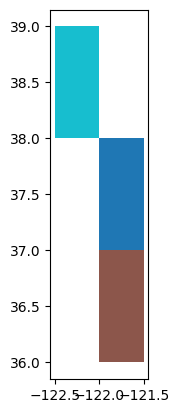

In [3]:
# The generous bounds of the reserves
reserve_bounds = gpd.GeoDataFrame(
    {
        "geometry":
            [
                box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
                box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
                box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)
            ],
        "reserve": ["Quail", "BORR", "Hastings"]
    },
    crs=4326
)
reserve_bounds.plot("reserve")

In [4]:
def ensure_non_overlapping_polygons(
    geometries: typing.Union[typing.List[Geometry], gpd.GeoDataFrame],
    inplace: bool = False,
):
    # Make sure geometries is a list of shapely objects
    if isinstance(geometries, gpd.GeoDataFrame):
        original_gdf = geometries
        geometries = geometries.geometry.tolist()
    else:
        original_gdf = None

    output_geometries = [None] * len(geometries)
    union_of_added_geoms = MultiPolygon()

    areas = [geom.area for geom in geometries]
    sorted_inds = np.argsort(areas)

    for ind in sorted_inds:
        # Get the input geometry and ensure it's valid
        geom = make_valid(geometries[ind])
        # Subtract the union of all
        geom_to_add = difference(geom, union_of_added_geoms)
        output_geometries[ind] = geom_to_add
        # Add the original geom, not the difference'd one, to avoid boundary artifacts
        union_of_added_geoms = union(geom, union_of_added_geoms)

    if original_gdf is None:
        return output_geometries
    elif inplace:
        original_gdf.geometry = output_geometries
    else:
        output_gdf = original_gdf.copy()
        output_gdf.geometry = output_geometries
        return output_gdf

def ensure_projected_CRS(geodata: gpd.GeoDataFrame):
    """Returns a projected geodataframe from the provided geodataframe by converting it to
    ESPG:4326 (if not already) and determining the projected CRS from the point
    coordinates.

    Args:
        geodata (gpd.GeoDataGrame): Original geodataframe that is potentially unprojected
    Returns:
        gpd.GeoDataGrame: projected geodataframe
    """
    # If CRS is projected return immediately
    if geodata.crs.is_projected:
        return geodata

    # If CRS is geographic and not long-lat, convert it to long-lat
    if geodata.crs.is_geographic and geodata.crs != LAT_LON_CRS:
        geodata = geodata.to_crs(LAT_LON_CRS)

    # Convert geographic long-lat CRS to projected CRS
    point = geodata["geometry"].iloc[0].centroid
    geometric_crs = get_projected_CRS(lon=point.x, lat=point.y)
    return geodata.to_crs(geometric_crs)


def get_projected_CRS(lat, lon, assume_western_hem=True):
    if assume_western_hem and lon > 0:
        lon = -lon
    # https://gis.stackexchange.com/questions/190198/how-to-get-appropriate-crs-for-a-position-specified-in-lat-lon-coordinates
    epgs_code = 32700 - round((45 + lat) / 90) * 100 + round((183 + lon) / 6)
    crs = pyproj.CRS.from_epsg(epgs_code)
    return crs

In [5]:
def plot_map(gdf, title=None):
    ax = gdf.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)
    if title is not None:
        ax.set_title(title)

In [6]:
def compute_standardized(
    preds, shared_region, reserve, year, ensure_nonoverlapping=False
):
    if len(preds) == 0:
        return None

    if ensure_nonoverlapping:
        # Since geofileops requires files to be on disk, we create a temporary directory to hold
        # all the intermediate files. All the content will be deleted when the directory object
        temp_dir = tempfile.TemporaryDirectory()
        preds_file = Path(temp_dir.name, "preds.gpkg")
        shared_region_file = Path(temp_dir.name, "shared_region.gpkg")
        clipped_file = Path(temp_dir.name, "clipped.gpkg")
        merged_file = Path(temp_dir.name, "merged.gpkg")

        # Write the
        preds.to_file(preds_file)
        shared_region.to_file(shared_region_file)
        print("About to clip")
        gfo.clip(
            input_path=preds_file,
            output_path=clipped_file,
            clip_path=shared_region_file,
        )
        print("Clipped")
        print("About to dissolve")
        gfo.dissolve(
            input_path=clipped_file,
            output_path=merged_file,
            groupby_columns=["class_names", "class_ID"],
            explodecollections=False,
            agg_columns={
                "columns": [
                    {"column": "mission_id", "agg": "min", "as": "mission_id"},
                    {"column": "earliest_datetime_local_derived", "agg": "min", "as": "earliest_datetime_local_derived"},
                    {"column": "reserve", "agg": "min", "as": "reserve"},
                ]
            },
        )
        print("dissolved")
        dissolved = gpd.read_file(merged_file)
        subset = ensure_non_overlapping_polygons(dissolved)

        # One of the gfo operations turns this column into an interger denoting the millisecond epoch
        # time rather than recording it as a datetime object. Convert it back.
        subset["earliest_datetime_local_derived"] = pd.to_datetime(subset["earliest_datetime_local_derived"], unit="ms")
        display(subset)
    else:
        # Merge all instances of the same class across all predicted datasets
        dissolved = preds.dissolve(by="class_names", as_index=False)
        plot_map(dissolved, title=f"{year}: before clipping")

        subset = dissolved.clip(shared_region)

    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../../data/vis/final_cover_{reserve}_{year}.png"))

    subset = ensure_projected_CRS(subset)
    # Clean up the geometry
    subset.geometry = subset.buffer(0)
    # Compute the area fraction
    total_area = (
        gpd.GeoDataFrame(data={"geometry": shared_region}, crs=4326)
        .to_crs(subset.crs)
        .area.values[0]
    )

    subset["area_fraction"] = subset.area / total_area
    subset.to_file(Path(f"../../data/vis/final_cover_{reserve}_{year}.gpkg"))

    return subset


def compute_transition_matrix(first_class_df, second_class_df, reserve, first_year=None, second_year=None):
    overlay = first_class_df.overlay(second_class_df)

    # Get the classes for the left and right dataframes
    i_inds = overlay["class_ID_1"].to_numpy().astype(int)
    j_inds = overlay["class_ID_2"].to_numpy().astype(int)
    # Get the areas of the overlaps
    values = overlay.area.to_numpy()

    # Build a matrix to populate
    transition_matrix = np.zeros((8, 8))
    transition_matrix[i_inds, j_inds] = values
    transition_matrix_row_normed = transition_matrix / np.expand_dims(
        transition_matrix.sum(axis=1), axis=1
    )

    # Compute the years from the dataframes if not provided
    if first_year is None:
        first_year = (
            first_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )
    if second_year is None:
        second_year = (
            second_class_df["earliest_datetime_local_derived"]
            .dt.strftime("%Y")
            .astype(int)[0]
        )

    # Display the results
    ConfusionMatrixDisplay(transition_matrix, display_labels=CLASS_NAMES).plot()
    plt.title(f"Transition matrix for {reserve} for {first_year}-{second_year}")
    plt.xticks(rotation=70)
    plt.savefig(
        Path(f"../../data/vis/transition_{reserve}_{first_year}_{second_year}.png")
    )
    plt.show()
    # Show the results with each row normalized to a sum of one
    ConfusionMatrixDisplay(
        transition_matrix_row_normed, display_labels=CLASS_NAMES
    ).plot()
    plt.title(
        f"Transition matrix (row-normalized) for {reserve} for {first_year}-{second_year}"
    )
    plt.xticks(rotation=70)
    plt.savefig(
        Path(
            f"../../data/vis/transition_normalized_{reserve}_{first_year}_{second_year}.png"
        )
    )
    plt.show()

In [7]:
metadata = gpd.read_file(METADATA_FILE)
metadata = metadata[["mission_id", "earliest_datetime_local_derived"]]

In [8]:
pred_files = sorted(PREDS_FOLDER.glob("*"))

# Load predictions

<Axes: >

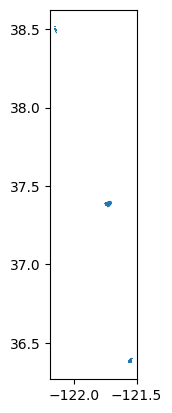

In [9]:
preds = []

for pred_file in pred_files:
    pred = gpd.read_file(pred_file)
    pred["mission_id"] = pred_file.stem
    # Something is weird with this dataset and it's a collection of individual polygons
    if pred_file.stem == "000559":
        pred = pred.dissolve("class_names", as_index=False)

    preds.append(pred)

all_preds = pd.concat(preds)
all_preds.plot()

# Add additional information

In [10]:
# Combine the metadata with the predictions
all_preds = all_preds.merge(metadata, on="mission_id")

# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = all_preds["earliest_datetime_local_derived"].dt.strftime('%m%d').astype(int)

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, reserve_bounds, how="left", predicate="intersects")

166 rows dropped


Subset to a single reserve

In [11]:
# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [12]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]
print(f"There are {preds_2020['mission_id'].unique()} from 2020, {preds_2023['mission_id'].unique()} from 2023, and {preds_2024['mission_id'].unique()} from 2024")

There are ['000546' '000547' '000548' '000549' '000551' '000555' '000558' '000559'
 '000563' '001336' '001337'] from 2020, ['000610' '000611' '000612' '000613'] from 2023, and [] from 2024


Compute the shared region across non-empty reserves

<Axes: >

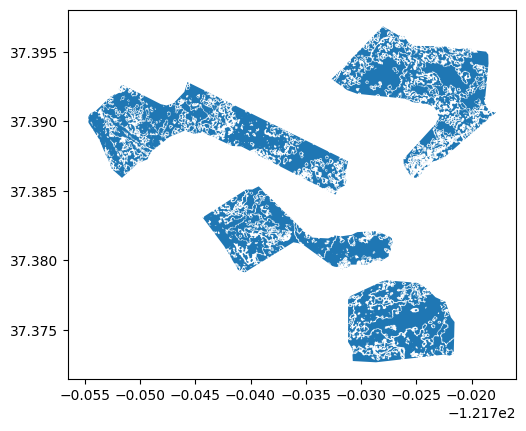

In [13]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

In [14]:
preds_2020

,class_ID,class_names,geometry,mission_id,earliest_datetime_local_derived,index_right,reserve
19,4.0,SL_shrub_live,"POLYGON ((-121.7237 37.39215, -121.72371 37.39...",000546,2020-05-09 14:00:16+00:00,1,BORR
20,2.0,MM_man_made_object,"POLYGON ((-121.72353 37.39416, -121.72353 37.3...",000546,2020-05-09 14:00:16+00:00,1,BORR
21,5.0,TD_tree_dead,"MULTIPOLYGON (((-121.7231 37.39454, -121.72308...",000546,2020-05-09 14:00:16+00:00,1,BORR
22,6.0,TL_tree_live,"MULTIPOLYGON (((-121.72319 37.39443, -121.7231...",000546,2020-05-09 14:00:16+00:00,1,BORR
23,1.0,HL_herbaceous_live,"MULTIPOLYGON (((-121.72454 37.39387, -121.7245...",000546,2020-05-09 14:00:16+00:00,1,BORR
...,...,...,...,...,...,...,...
309,6.0,TL_tree_live,"MULTIPOLYGON (((-121.72009 37.3942, -121.72008...",001336,2020-09-23 02:11:03+00:00,1,BORR
310,0.0,BE_bare_earth,"MULTIPOLYGON (((-121.72621 37.39235, -121.7262...",001337,2020-09-22 12:47:05+00:00,1,BORR
311,2.0,MM_man_made_object,"MULTIPOLYGON (((-121.72385 37.39266, -121.7238...",001337,2020-09-22 12:47:05+00:00,1,BORR
312,5.0,TD_tree_dead,"MULTIPOLYGON (((-121.71899 37.39266, -121.7189...",001337,2020-09-22 12:47:05+00:00,1,BORR


INFO:geofileops.clip:Start on /tmp/tmp2oot0i7d/preds.gpkg with /tmp/tmp2oot0i7d/shared_region.gpkg to /tmp/tmp2oot0i7d/clipped.gpkg


About to clip


INFO:geofileops.util._sqlite_util:get_columns ready, took 6.05 seconds
INFO:geofileops.clip:Start processing (1 parallel workers, batch size: 61)


00:00:00 left, clip done on 1 of 1 (100.00%)    


INFO:geofileops.clip:Ready, took 0:04:17.601751
INFO:geofileops.dissolve:Start, on /tmp/tmp2oot0i7d/clipped.gpkg to /tmp/tmp2oot0i7d/merged.gpkg
INFO:geofileops.dissolve:Start, with input /tmp/tmp2oot0i7d/clipped.gpkg
INFO:geofileops.dissolve:Start pass 0 to 1 tiles (batch size: 57)


Clipped
About to dissolve
00:00:00 left, dissolve done on 1 of 1 (100.00%)    


INFO:geofileops.dissolve:Pass 0 ready, took 0:00:08.280524
INFO:geofileops.dissolve:Finalize result
INFO:geofileops.dissolve:Ready, full dissolve took 0:00:09.185386


dissolved


,class_names,class_ID,mission_id,earliest_datetime_local_derived,reserve,geometry
0,TL_tree_live,6.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72172 37.37326, -121.7217..."
1,BE_bare_earth,0.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72175 37.37327, -121.7217..."
2,TD_tree_dead,5.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72181 37.37345, -121.7218..."
3,HL_herbaceous_live,1.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72381 37.39131, -121.7238..."
4,SL_shrub_live,4.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72156 37.38876, -121.7215..."
5,MM_man_made_object,2.0,000546,2020-05-09 14:00:16,BORR,"MULTIPOLYGON (((-121.72177 37.39156, -121.7217..."
6,W_water,7.0,000548,2020-05-20 11:03:35,BORR,"MULTIPOLYGON (((-121.73999 37.37977, -121.7399..."
7,SD_shrub_dead,3.0,000559,2020-10-26 21:06:22,BORR,"POLYGON ((-121.74406 37.38956, -121.74406 37.3..."


INFO:geofileops.clip:Start on /tmp/tmpiawmdhzf/preds.gpkg with /tmp/tmpiawmdhzf/shared_region.gpkg to /tmp/tmpiawmdhzf/clipped.gpkg


About to clip


INFO:geofileops.util._sqlite_util:get_columns ready, took 5.72 seconds
INFO:geofileops.clip:Start processing (1 parallel workers, batch size: 22)


00:00:00 left, clip done on 1 of 1 (100.00%)    


INFO:geofileops.clip:Ready, took 0:01:41.252361
INFO:geofileops.dissolve:Start, on /tmp/tmpiawmdhzf/clipped.gpkg to /tmp/tmpiawmdhzf/merged.gpkg
INFO:geofileops.dissolve:Start, with input /tmp/tmpiawmdhzf/clipped.gpkg
INFO:geofileops.dissolve:Start pass 0 to 1 tiles (batch size: 22)


Clipped
About to dissolve
00:00:00 left, dissolve done on 1 of 1 (100.00%)    


INFO:geofileops.dissolve:Pass 0 ready, took 0:00:03.844423
INFO:geofileops.dissolve:Finalize result
INFO:geofileops.dissolve:Ready, full dissolve took 0:00:04.181749


dissolved


,class_names,class_ID,mission_id,earliest_datetime_local_derived,reserve,geometry
0,TL_tree_live,6.0,000610,2023-08-17 16:17:37,BORR,GEOMETRYCOLLECTION (POLYGON ((-121.72844 37.37...
1,BE_bare_earth,0.0,000610,2023-08-17 16:17:37,BORR,"MULTIPOLYGON (((-121.75246 37.3867, -121.75246..."
2,SL_shrub_live,4.0,000610,2023-08-17 16:17:37,BORR,"MULTIPOLYGON (((-121.72706 37.37518, -121.7270..."
3,TD_tree_dead,5.0,000610,2023-08-17 16:17:37,BORR,"MULTIPOLYGON (((-121.72851 37.37778, -121.7285..."
4,HL_herbaceous_live,1.0,000611,2023-08-17 16:46:11,BORR,"MULTIPOLYGON (((-121.74087 37.38033, -121.7408..."
5,W_water,7.0,000611,2023-08-17 16:46:11,BORR,"MULTIPOLYGON (((-121.73991 37.37987, -121.7399..."
6,MM_man_made_object,2.0,000611,2023-08-17 16:46:11,BORR,"MULTIPOLYGON (((-121.72823 37.38003, -121.7282..."


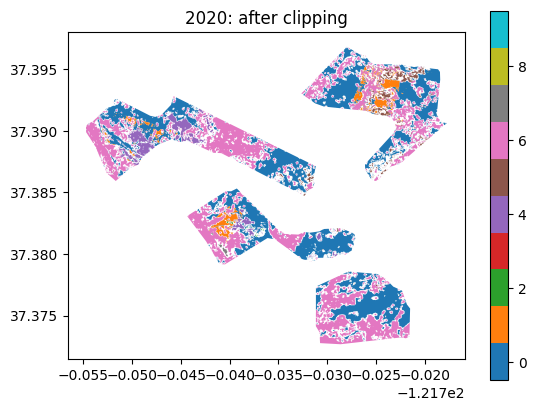

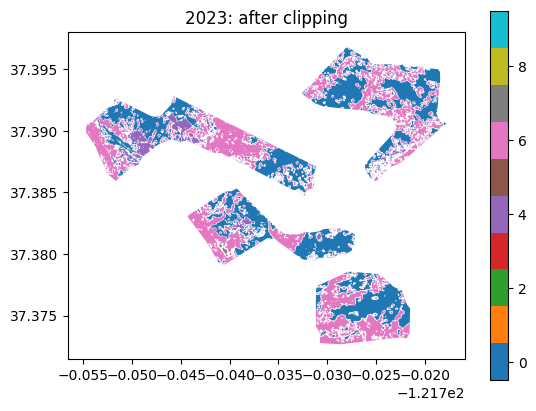

In [15]:
if True:
    standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2023 = compute_standardized(preds_2023, shared_region, reserve=RESERVE, year="2023", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
    standardized_2024 = compute_standardized(preds_2024, shared_region, reserve=RESERVE, year="2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
else:
    import geopandas as gpd
    standardized_2020 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2020.gpkg")
    standardized_2023 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2023.gpkg")
    standardized_2024 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2024.gpkg")

Make a table to summarize the class fractions per

In [16]:
final_table = np.zeros((8,3))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy().astype(int), 1] = standardized_2023["area_fraction"]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy().astype(int), 2] = standardized_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=CLASS_NAMES)
final_table_vis

,2020,2023,2024
Bare Earth,4.725475e-01,0.500102,0.0
Herbaceous Live,3.864102e-02,0.000001,0.0
Man Made,5.140624e-04,0.000484,0.0
Shrub Dead,8.631480e-07,0.000000,0.0
Shrub Live,4.723537e-02,0.057032,0.0
Tree Dead,2.290090e-02,0.000193,0.0
Tree Live,4.168199e-01,0.440961,0.0
Water,1.340339e-03,0.001227,0.0


/home/exouser/miniconda3/envs/geofileops/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 8179 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


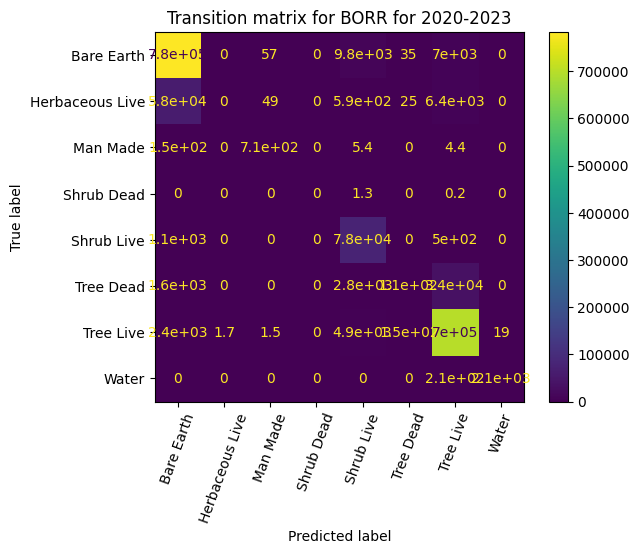

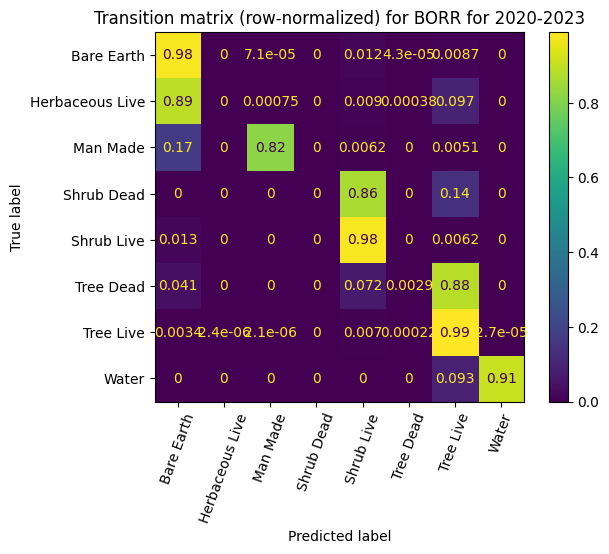

In [17]:
if standardized_2020 is not None and standardized_2023 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023, reserve=RESERVE)

if standardized_2020 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2024, reserve=RESERVE)

if standardized_2023 is not None and standardized_2024 is not None:
    compute_transition_matrix(standardized_2023, standardized_2024, reserve=RESERVE)

# Merged 2023-2024

This section repeats the last few steps of the last section but after merging the 2023 and 2024 years since they both occured after significant regrowth

<Axes: >

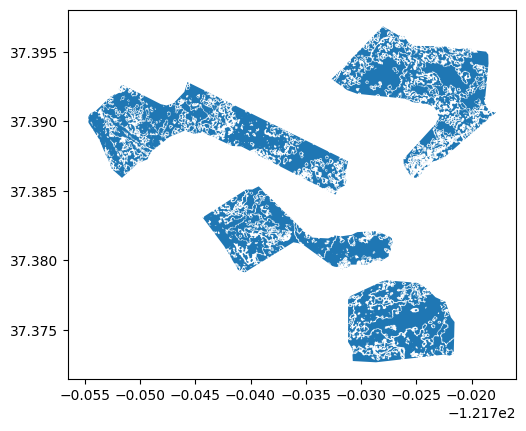

In [18]:
preds_2023_2024 = pd.concat([preds_2023, preds_2024])

boundary_2020 = preds_2020.dissolve()
boundary_2023_2024 = preds_2023_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
# Compute the union of all the reserves
shared_region = pd.concat((boundary_2020, boundary_2023_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023_2024) > 0:
    shared_region = shared_region.intersection(boundary_2023_2024)

shared_region.plot()

In [19]:
standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020-merged-years", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
standardized_2023_2024 = compute_standardized(preds_2023_2024, shared_region, reserve=RESERVE, year="2023-2024", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)

INFO:geofileops.clip:Start on /tmp/tmpfwi11_ut/preds.gpkg with /tmp/tmpfwi11_ut/shared_region.gpkg to /tmp/tmpfwi11_ut/clipped.gpkg


About to clip


INFO:geofileops.util._sqlite_util:get_columns ready, took 6.40 seconds
INFO:geofileops.clip:Start processing (1 parallel workers, batch size: 61)


 ?: ?: ? left, clip done on 0 of 1 (0.00%)    

KeyboardInterrupt: 

INFO:geofileops.clip:Start on /tmp/tmpuh2u70e_/preds.gpkg with /tmp/tmpuh2u70e_/shared_region.gpkg to /tmp/tmpuh2u70e_/clipped.gpkg


About to clip


INFO:geofileops.util._sqlite_util:get_columns ready, took 12.35 seconds
INFO:geofileops.clip:Start processing (1 parallel workers, batch size: 14)


00:00:00 left, clip done on 1 of 1 (100.00%)    


INFO:geofileops.clip:Ready, took 0:02:02.772950
INFO:geofileops.dissolve:Start, on /tmp/tmpuh2u70e_/clipped.gpkg to /tmp/tmpuh2u70e_/merged.gpkg
INFO:geofileops.dissolve:Start, with input /tmp/tmpuh2u70e_/clipped.gpkg
INFO:geofileops.dissolve:Start pass 0 to 1 tiles (batch size: 11)


Clipped
About to dissolve
00:00:00 left, dissolve done on 1 of 1 (100.00%)    


INFO:geofileops.dissolve:Pass 0 ready, took 0:00:03.819693
INFO:geofileops.dissolve:Finalize result
INFO:geofileops.dissolve:Ready, full dissolve took 0:00:04.185380


dissolved


,class_names,class_ID,mission_id,earliest_datetime_local_derived,reserve,geometry
0,TL_tree_live,6.0,000576,2020-09-27 00:58:52,Hastings,"MULTIPOLYGON (((-121.56422 36.37937, -121.5642..."
1,SL_shrub_live,4.0,000576,2020-09-27 00:58:52,Hastings,"MULTIPOLYGON (((-121.56399 36.3797, -121.56399..."
2,BE_bare_earth,0.0,000576,2020-09-27 00:58:52,Hastings,"MULTIPOLYGON (((-121.56408 36.37938, -121.5640..."
3,TD_tree_dead,5.0,000576,2020-09-27 00:58:52,Hastings,"MULTIPOLYGON (((-121.56412 36.37945, -121.5641..."
4,MM_man_made_object,2.0,000576,2020-09-27 00:58:52,Hastings,"MULTIPOLYGON (((-121.56484 36.3824, -121.56484..."
5,SD_shrub_dead,3.0,000578,2020-09-28 00:58:15,Hastings,"MULTIPOLYGON (((-121.56205 36.38437, -121.5620..."


2    MULTIPOLYGON (((630623.081 4028676.75, 630622....
Name: geometry, dtype: geometry

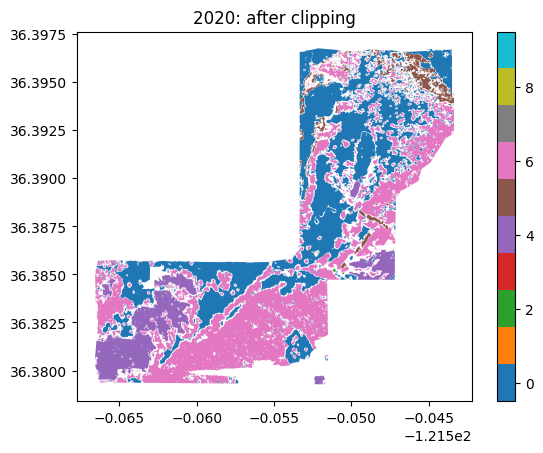

In [ ]:
#standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020", ensure_nonoverlapping=ENSURE_NONOVERLAPPING)
#standardized_2020.query("class_names == 'BE_bare_earth'")["geometry"]

In [ ]:
final_table = np.zeros((8,2))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023_2024 is not None:
    final_table[standardized_2023_2024["class_ID"].to_numpy().astype(int), 1] = standardized_2023_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023-2024"],
    index=CLASS_NAMES)
final_table_vis

,2020,2023-2024
Bare Earth,4.200541e-01,0.266877
Herbaceous Live,0.000000e+00,0.045645
Man Made,3.580884e-04,0.000306
Shrub Dead,3.987591e-07,0.000000
Shrub Live,1.178844e-01,0.224361
Tree Dead,3.608806e-02,0.001754
Tree Live,4.256150e-01,0.461057
Water,0.000000e+00,0.000000


/home/exouser/miniconda3/envs/geofileops/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 835 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/tmp/ipykernel_12163/4028963766.py:86: RuntimeWarning: invalid value encountered in divide
  transition_matrix_row_normed = transition_matrix / np.expand_dims(


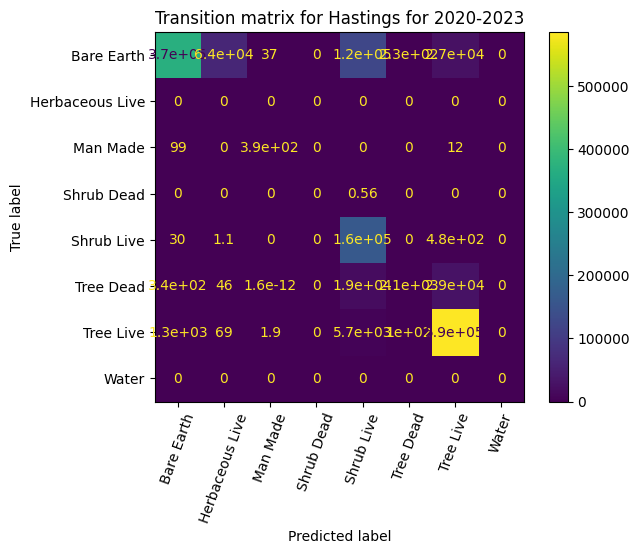

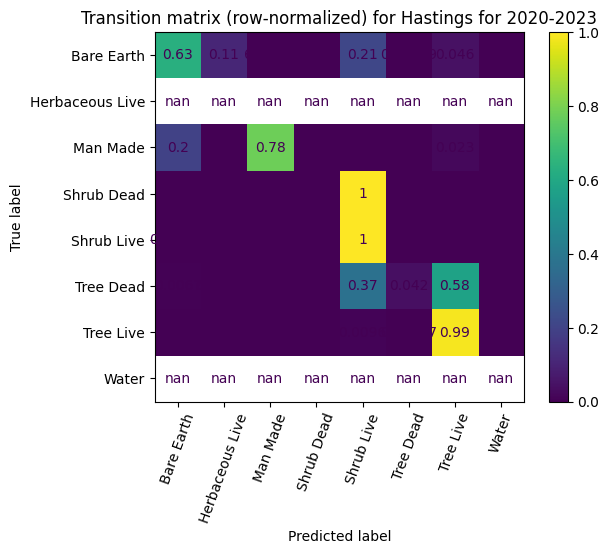

In [ ]:
if standardized_2020 is not None and standardized_2023_2024 is not None:
    compute_transition_matrix(standardized_2020, standardized_2023_2024, reserve=RESERVE, first_year="2020-merged-years", second_year="2023-2024")